<a href="https://colab.research.google.com/github/cvaf/fut/blob/master/pricey/sophie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

# other
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
from time import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-muted', 'dark_background'])
%matplotlib inline


# processing & model selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

np.random.seed(410)

In [2]:
# models
try:
    %tensorflow_version 2.x
except Exception:
    pass
  
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Concatenate, Layer, add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)

TensorFlow 2.x selected.
2.0.0-rc1


# Price Prediction

**Table of Contents**:
1. Feature Engineering
2. Transformation
3. Modeling

In [0]:
df = pd.read_csv('../data/prices_database.csv', index_col='Unnamed: 0', parse_dates=['added_date', 'date'])
df.head(2)

,player_name,quality,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,num_games,avg_goals,avg_assists,date,price
0,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,"140,067",0.58,0.38,2018-09-20,0
1,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,"140,067",0.58,0.38,2018-09-21,0


# 1. Feature Engineering

We need to construct and/or engineer the following features:
- days: number of days specific card has been available
- weekday: day of the week
- gen_pos: general player position - one of: ['defender', 'midfielder', 'forward']
- club/league/nationality grouping: group clubs and leagues according to popularity to avoid sparsity. 
- promo: binary variable indicating whether there was an active promotion.
- source: how one can obtain the card: ['base', 'packs', 'loan', 'objective', 'sbc'] - intentional overlap between base and packs
- available: binary variable indicating whether the card was obtainable on that day.
- days_release: number of days since game release

**Days**:

In [0]:
df['days'] = (df['date'] - df['added_date']).dt.days

Quick to note that some players have prices for the day before they were officially released, implying there's a mistake. Further investigation reveals that these should be offset to the next day instead. 

In [0]:
offset_resources = df[df.days == -1].resource_id.unique()       # get resource id of users who match this 

df['date'] = np.where(df.resource_id.isin(offset_resources),    # remap the date variable
                      df.date +pd.DateOffset(days=1), df.date)
df['days'] = (df.date - df.added_date).dt.days                  # reassign the days variable

df = df[df.days >= 0]                                           # remove observations that have days < 0

df['days'] = (df.days+1)/365
df['days'] = np.log(df.days) - np.log(1-df.days)

**Weekday**:

In [0]:
df['weekday'] = df.date.dt.weekday                              # get the day of the week

**General Position**:

In [0]:
for_pos = ['ST', 'CF', 'CAM', 'LW', 'LF', 'LM', 'RW', 'RF', 'RM']
mid_pos = ['CM', 'CDM']
def_pos = ['LB', 'LWB', 'CB', 'RB', 'RWB']

df['gen_pos'] = np.where(df.position.isin(for_pos), 'forward', np.nan)
df['gen_pos'] = np.where(df.position.isin(mid_pos), 'midfielder', df.gen_pos)
df['gen_pos'] = np.where(df.position.isin(def_pos), 'defender', df.gen_pos)

**Club/League/Nation**:

Group all leagues outside of top5 - repeat the same with teams.

Nations: Mark the 10 most common nations as 1, others 0

In [0]:
df = df[df.club != 'Icons']  # drop icons

# top 5 leagues
t_leagues = ['Premier League', 'Serie A TIM', 'LaLiga Santander', 'Ligue 1 Conforama', 'Bundesliga']
df['league'] = np.where(df.league.isin(t_leagues), df.league, 'other')

# top clubs
t_clubs = ['Manchester United', 'Manchester City', 'Chelsea', 'Liverpool', 'Arsenal', 'Tottenham Hotspur',
           'Paris Saint-Germain', 'Juventus', 'Napoli', 'Inter', 'FC Barcelona', 'Real Madrid', 'Atlético Madrid',
           'Borussia Dortmund', 'FC Bayern München']
df['club'] = np.where(df.club.isin(t_clubs), df.club, 'other')

In [0]:
# top nations
t_nations = ['Spain', 'France', 'Brazil', 'Germany', 'Argentina', 'England',
             'Italy', 'Portugal', 'Holland', 'Belgium']
df['nationality'] = np.where(df.nationality.isin(t_nations), df.nationality, 'other')

**Promo**:

In [0]:
promos = [[datetime(2019, 5, 10), datetime(2019, 6, 21)],       # TOTS
          [datetime(2019, 4, 5), datetime(2019, 4, 15)],        # icon release
          [datetime(2019, 3, 22), datetime(2019, 3, 30)],       # fut bday
          [datetime(2019, 3, 8), datetime(2019, 3, 16)],        # carniball
          [datetime(2019, 2, 15), datetime(2019, 2, 24)],       # rating refresh
          [datetime(2019, 2, 1), datetime(2019, 2, 8)],         # headliners
          [datetime(2019, 1, 18), datetime(2019, 1, 25)],       # ffs
          [datetime(2019, 1, 7), datetime(2019, 1, 14)],        # TOTY
          [datetime(2018, 12, 14), datetime(2018, 12, 24)],     # futmas
          [datetime(2018, 12, 7), datetime(2018, 12, 14)],      # totgs
          [datetime(2018, 11, 23), datetime(2018, 11, 26)],     # black friday
          [datetime(2018, 11, 9), datetime(2018, 11, 16)],      # rttf
          [datetime(2018, 10, 19), datetime(2018, 10, 26)]]     # halloween

def promo_assignment(ds):
    date = pd.to_datetime(ds)
    promo = 0
    for p in promos:
        if (p[0] <= date) & (p[1] >= date):
            promo = 1
            break
    return promo

df['promo'] = df['date'].apply(promo_assignment)                # apply the promo assignment

**Card Source**:

In [0]:
df.revision.fillna('MLS POTM', inplace=True)

df['source'] = 'packs'

# base cards
base = ['Normal', 'Winter Refresh']
df['source'] = np.where(df.revision.isin(base), 'packs', df.source)

# sbc cards
sbc = ['SBC', 'POTM']
df['source'] = np.where(df.revision.apply(lambda x: any(i.lower() in x.lower() for i in sbc)), 'sbc', df.source)

# loan cards
df['source'] = np.where(df.revision.str.contains('Loan'), 'loan', df.source) 
df = df[df.source != 'loan'] # remove loans

# objective cards
df['source'] = np.where(df.revision.str.contains('Ob'), 'objective', df.source)


# overwrite source for cards that were both objectives and in packs (TOTS Rodri)
resources = df[df.price>0].resource_id.unique()
df['source'] = np.where(df.resource_id.isin(resources), 'packs', df.source)

**Availability**:
- Pack cards: will be labeled as available for a week after being added to the database. This isn't always accurate but an overall approximation.
- SBC: Availability will also be set for a week - again, an approximation. 
- Objectives: Weekly availability
- Winter Upgrades + Base Cards: Available throughout except periods where they have special cards in packs. Winter upgrades replace base cards. 

In [0]:
df['available'] = np.nan

# special cards in packs, sbcs and objectives
is_special = ((df.source == 'packs') | (df.source == 'sbc') | (df.source == 'objective'))
is_available = (df.date <= (df.added_date + pd.DateOffset(7)))

df['available'] = np.where(is_special & is_available, 1, df.available)

# create a cross product to find the availability of base cards from special pack cards
base = df[df.source == 'base'][['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'available', 'resource_id']]
pack = df[df.source == 'packs'][['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'available']]
overlap = base.merge(pack, on=['player_name', 'age', 'height', 'weight', 'intl_rep', 'date'], how='inner', suffixes=('', '_special'))

overlap['available'] = np.where(overlap.available_special == 1, 0, 1)

# group by to handle multiple special card instances
overlap = overlap.groupby(['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'resource_id']).available.min().reset_index()

df_ = df.merge(overlap, on=['date', 'resource_id' ,'added_date', 'player_name'], how='left', suffixes=('', '_overlap'))

df['available'] = np.where(df.source == 'base', df_.available_overlap, df.available)          # update the availability of base cards that had special cards at some point
df['available'] = np.where((df.source == 'base') & (df.available.isnull()), 1, df.available)  # update the availability of the rest of the base cards
df.available.fillna(0, inplace=True)                                                          # update the availability of the rest of the cards

**Days Since Release**:

In [0]:
df['days_release'] = (df.date - df.date.min()).dt.days + 1
df['days_release'] = df.days_release / 365
df['days_release'] = np.log(df.days_release) - np.log(1-df.days_release)

**PGP Statistics**:

In [0]:
df['avg_goals'] = pd.to_numeric(df.avg_goals.replace('-', 0))
df['avg_assists'] = pd.to_numeric(df.avg_assists.replace('-', 0))

**Relative Price**:

In [0]:
df.sort_values(by=['resource_id', 'date'], ascending=True, inplace=True)
df_ = df.shift(1)
df['relative_price'] = np.where(df.resource_id == df_.resource_id, df.price*100/df_.price, 'first')
df = df[df.relative_price!='first']

**Narrow selection and projection**:

We don't need all the remaining columns, so we narrow down our projection before proceeding.

In [0]:
drop_cols = ['quality', 'age', 'pace', 'pace_acceleration', 'pace_sprint_speed', 'drib_agility', 'drib_balance',
             'drib_reactions', 'drib_ball_control', 'drib_dribbling', 'shoot_positioning', 'shoot_finishing', 'shoot_shot_power',
             'shoot_long_shots', 'shoot_volleys', 'shoot_penalties', 'pass_vision', 'pass_crossing', 'pass_free_kick', 'pass_short',
             'pass_long', 'pass_curve', 'def_interceptions', 'def_heading', 'def_marking', 'def_stand_tackle', 'def_slid_tackle', 
             'phys_jumping', 'phys_strength', 'phys_aggression', 'pref_foot', 'num_games', 'added_date', 'position']
df.drop(drop_cols, axis=1, inplace=True)

For the purpose of our project, we remove players with 0 target and only keep those with a rating of 81 or greater. 

In [0]:
df = df[(df.price!=0) & (df.overall>80)].reset_index(drop=True)
df.head(2)

,player_name,overall,club,league,nationality,height,weight,intl_rep,dribbling,drib_composure,shooting,passing,defending,physicality,phys_stamina,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,avg_goals,avg_assists,date,price,days,weekday,gen_pos,promo,source,available,days_release,relative_price
0,Iniesta,87,other,other,Spain,171,68,4,90.0,89,70.0,87.0,61.0,57.0,55,High,Med,4,4,41,0.14,0.18,2018-09-21,7807,-4.793032,4,midfielder,0,packs,1.0,-5.201256,111.00526091283947
1,Iniesta,87,other,other,Spain,171,68,4,90.0,89,70.0,87.0,61.0,57.0,55,High,Med,4,4,41,0.14,0.18,2018-09-22,8714,-4.502584,5,midfielder,0,packs,1.0,-4.793032,111.61777891635711


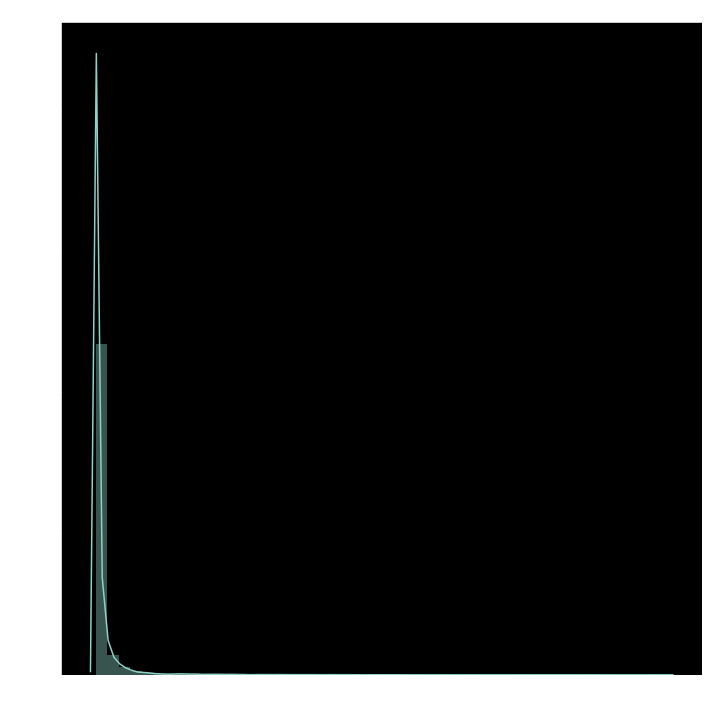

In [0]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.distplot(df.price.values, ax=ax)
ax.set_title('Price Distribution')
plt.tight_layout(); plt.show()

In [0]:
# eliminating "expensive" players -- outliers basically
expensive_resources = df[df.price>300000].resource_id.unique()
df=df[~df.resource_id.isin(expensive_resources)]

In [0]:
df.to_pickle('../data/sophie_dataset.pkl')

# 2. Processing

Due to the complex nature of our dataset, where some of its attributes are temporal and some are not, our model will consist of two separate inputs to account for this. 

In [0]:
df = pd.read_pickle('../data/sophie_dataset.pkl')

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_pickle('drive/My Drive/Python/Fut/sophie_dataset.pkl')

In [5]:
df.head(2)

,player_name,overall,club,league,nationality,height,weight,intl_rep,dribbling,drib_composure,shooting,passing,defending,physicality,phys_stamina,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,avg_goals,avg_assists,date,price,days,weekday,gen_pos,promo,source,available,days_release,relative_price
0,Iniesta,87,other,other,Spain,171,68,4,90.0,89,70.0,87.0,61.0,57.0,55,High,Med,4,4,41,0.14,0.18,2018-09-21,7807,-4.793032,4,midfielder,0,packs,1.0,-5.201256,111.00526091283947
1,Iniesta,87,other,other,Spain,171,68,4,90.0,89,70.0,87.0,61.0,57.0,55,High,Med,4,4,41,0.14,0.18,2018-09-22,8714,-4.502584,5,midfielder,0,packs,1.0,-4.793032,111.61777891635711


In [0]:
test_split = datetime(2019, 3, 1)
df_train = df[df.date<test_split]
df_test = df[df.date>=test_split]

print('{} datapoints in Training Set\n{} datapoints in Test Set'.format(df_train.shape[0], df_test.shape[0]))

124632 datapoints in Training Set
119208 datapoints in Test Set


In [0]:
drop_cols = ['player_name', 'resource_id', 'date']
temp_cols = ['promo', 'weekday', 'available', 'relative_price', 'price']
attr_cols = [c for c in df.columns if c not in (drop_cols + temp_cols)]
target = 'price'

### Temporal Transformation

In [0]:
df_train_temp = df_train.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)
df_test_temp = df_test.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)

In [0]:
df_train_temp.head(3)

,date,promo,available,relative_price,price
resource_id,,,,,
41,2018-09-21,0,1.0,111.00526091283947,7807
41,2018-09-22,0,1.0,111.61777891635711,8714
41,2018-09-23,0,1.0,105.73789304567363,9214


In [0]:
assert df_train_temp.shape[1] == df_test_temp.shape[1]

### Attributes Transformation

In [0]:
df_train_attr = df_train.groupby('resource_id')[attr_cols].first()
df_test_attr = df_test.groupby('resource_id')[attr_cols].first()

In [0]:
attr_cat = ['club', 'league', 'nationality', 'att_workrate', 'def_workrate', 'gen_pos', 'source']
attr_num = [v for v in df_train_attr.columns if v not in attr_cat]
num_mask = df_train_attr.columns.isin(attr_num)

ct = make_column_transformer((StandardScaler(), num_mask), (OneHotEncoder(), ~num_mask))
attr_ct = ct.fit(df_train_attr)

def attr_transform(df):
    resources = df.index.values
    cols = attr_num + attr_ct.named_transformers_['onehotencoder'].get_feature_names().tolist()
    data = attr_ct.transform(df)
    
    return pd.DataFrame(data=data, columns=cols, index=resources)

df_train_attr = attr_transform(df_train_attr)
df_test_attr = attr_transform(df_test_attr)

In [0]:
df_train_attr.head(3)

,overall,height,weight,intl_rep,dribbling,drib_composure,shooting,passing,defending,physicality,phys_stamina,weak_foot,skill_moves,avg_goals,avg_assists,days,weekday,days_release,x0_Arsenal,x0_Atlético Madrid,x0_Borussia Dortmund,x0_Chelsea,x0_FC Barcelona,x0_FC Bayern München,x0_Inter,x0_Juventus,x0_Liverpool,x0_Manchester City,x0_Manchester United,x0_Napoli,x0_Paris Saint-Germain,x0_Real Madrid,x0_Tottenham Hotspur,x0_other,x1_Bundesliga,x1_LaLiga Santander,x1_Ligue 1 Conforama,x1_Premier League,x1_Serie A TIM,x1_other,x2_Argentina,x2_Belgium,x2_Brazil,x2_England,x2_France,x2_Germany,x2_Holland,x2_Italy,x2_Portugal,x2_Spain,x2_other,x3_High,x3_Low,x3_Med,x4_High,x4_Low,x4_Med,x5_defender,x5_forward,x5_midfielder,x6_packs
41,1.491659,-1.551348,-1.118467,1.871713,1.361879,1.731676,-0.042582,1.391017,-0.053661,-2.003031,-2.613395,0.881270,0.828449,-0.357245,0.089985,-0.180399,0.669069,-1.199013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9014,0.626099,-0.223597,0.516591,1.871713,1.121456,1.004309,1.013559,0.712097,-1.510741,-1.414826,-1.587893,-1.834939,0.828449,0.173808,0.271626,-0.180399,0.669069,-1.199013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
20775,0.193319,-0.961236,-1.254722,0.706711,1.121456,0.095099,0.239056,0.825250,-1.912695,-1.414826,-1.473949,0.881270,2.002084,-0.067580,0.362446,-0.180399,0.669069,-1.199013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [0]:
assert df_test_attr.shape[1] == df_train_attr.shape[1]

### Input Processing

In [0]:
def data_process(df_temp, df_attr, num_obs, num_steps):
    """
    Constructs the temporal and attribute datasets for our model
    Arguments:
        - df_temp: our temporal dataframe
        - df_attr: our attributes dataframe
        - num_obs: number of observations to be used in model
        - num_steps: number of steps to predict
    Returns:
        - temp_data: temporal dataset
        - attr_data: attribute dataset
        - targ_data: target dataset
        - reso_data: corresponding resource
    """
    
    resources = df_temp.index.unique().values
    
    reso_data = []
    targ_data = []
    temp_data = []
    attr_data = []
    
    for r in resources:
        
        attributes = df_attr[df_attr.index==r].values[0]
        temporal_d = df_temp[df_temp.index==r].values
        
        total_obs = temporal_d.shape[0]
        window_size = num_obs + num_steps
        
        if window_size > total_obs:
            continue
        
        for i in range(total_obs - window_size):
            
            temp = temporal_d[i:i+num_obs][:, 1:]
            targ = temporal_d[i+num_obs:i+num_obs+num_steps][:, -1]
            targ_data.append(targ)
            temp_data.append(temp)
            attr_data.append(attributes)
            reso_data.append(r)
          
    return attr_data, temp_data, targ_data, reso_data

In [0]:
train_attr, train_temp, train_targ, train_res = data_process(df_train_temp, df_train_attr, 21, 4)
test_attr, test_temp, test_targ, test_res  = data_process(df_test_temp, df_test_attr, 21, 4)

In [0]:
train_attr = np.asarray(train_attr)
train_temp = np.asarray(train_temp)
train_targ = np.asarray(train_targ)
train_res = np.asarray(train_res)

test_attr = np.asarray(test_attr)
test_temp = np.asarray(test_temp)
test_targ = np.asarray(test_targ)
test_res = np.asarray(test_res)

In [0]:
assert train_res.shape[0] == train_temp.shape[0]
assert train_temp.shape[0] == train_targ.shape[0]
assert train_targ.shape[0] == train_attr.shape[0]

# Modeling
The temporal data will be fed into an LSTM layer, the attributes will be fed into a Dense layer; their outputs will be concatenated and fed into more layers. 

In [0]:
train_temp = train_temp.astype(np.float64)
test_temp = test_temp.astype(np.float64)

train_targ = train_targ.astype(np.int64)
test_targ = test_targ.astype(np.int64)

In [0]:
train_temp[0].shape

(21, 4)

In [0]:
train_attr[0].shape

(61,)

In [0]:
tf.random.set_seed(42)

input_attr = Input(shape=train_attr[0].shape)
input_temp = Input(shape=train_temp[0].shape)

# temporal path
X_temp1 = LSTM(4)(input_temp)
print(X_temp1.shape)

# attribute path
X_attr1 = Dense(64, activation='relu')(input_attr)

# merged path
X_3 = Concatenate(axis=1)([X_attr1, X_temp1])
X_4 = Dense(64, activation='relu')(X_3)
X_5 = Dense(64, activation='relu')(X_4)
X_6 = add([X_4, X_5])
X_7 = Dense(64, activation='relu')(X_6)
output = Dense(train_targ[0].shape[0])(X_7)

model = Model([input_attr, input_temp], output)
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

(None, 4)


In [0]:
history = model.fit([train_attr, train_temp], train_targ, epochs=10)

Train on 99587 samples
Epoch 1/10
99587/99587 [==============================] - 17s 172us/sample - loss: 1885941651.7411
Epoch 2/10
99587/99587 [==============================] - 16s 157us/sample - loss: 1854346491.9796
Epoch 3/10
99587/99587 [==============================] - 16s 163us/sample - loss: 1854727439.7990
Epoch 4/10
99587/99587 [==============================] - 16s 157us/sample - loss: 1854407672.7768
Epoch 5/10
99587/99587 [==============================] - 16s 157us/sample - loss: 1854032067.0414
Epoch 6/10
99587/99587 [==============================] - 16s 159us/sample - loss: 1854139875.7769
Epoch 7/10
99587/99587 [==============================] - 16s 157us/sample - loss: 1854375707.7781
Epoch 8/10
99587/99587 [==============================] - 15s 155us/sample - loss: 1854042911.1119
Epoch 9/10
99587/99587 [==============================] - 16s 156us/sample - loss: 1854260589.3617
Epoch 10/10
99587/99587 [==============================] - 16s 156us/sample - loss: 18

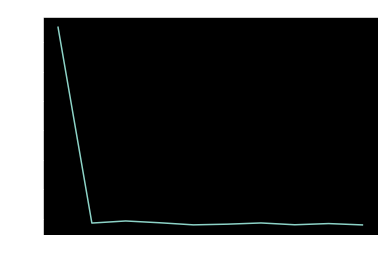

In [0]:
plt.plot(history.history['loss'])

In [0]:
2192947943.7490
1853913358.3275  16/64/32
2152751356.1010  16/64/32,32  2nd best performing
2114983308.4163  16/64/64,32  1st best performing  [34894.355, 34766.902, 34306.04 ]
1968274881.4705  32/64/64,32  ?                    [100917.52 , 101695.38 ,  99629.086]
2318939674.5350  16/64/64,32,16                    [213799.33, 213468.64, 211543.4 ]

2115874563.3787  3/64/64,32     0.05               [150093.81, 151375.16, 148452.22]
2062023516.1448  16/64/64,32    0.05                [56086.76 , 55897.707, 54982.184]

---------------------------------------------------------------------------------------
195360478.7640   16/64/64,32    0.05              [584.5263, 564.9278, 544.7306]
198287368.8941   16/64/64,64    0.05              [24600.693, 23996.002, 23725.465]

---------------------------------------------------------------------------------------
1853135986.2530  16/64/64.64.64 0.05              [29683.35 , 29607.271, 29482.93 , 29400.469]
1857605748.1090  16/64/64,64,64 0.05              [29305.691, 29403.244, 29292.22 , 29185.709]
1853954377.9496  16/64/64,64,64 0.1 w/ res        [30384.637, 30371.879, 30234.713, 30125.102]

In [0]:
test_preds = model.predict([test_attr, test_temp])

In [0]:
test_targ[0]

array([25614, 27028, 27839, 29744])

In [0]:
test_preds[0]

array([30377.81 , 30370.516, 30232.824, 30121.395], dtype=float32)

# Model Evaluation

Other than the loss metric used above, we can also plot some of the predictions as to get an idea of the model's performance.

In [0]:
def plot_predictions(i):
    """
    plot the predictions for index i in the test set
    """
    resource_id = test_res[i]
    player_name = df_test[df_test.resource_id==resource_id].player_name.values[0]
    prev_prices = test_temp[i][:, -1]
    actual_prices = test_targ[i]
    prices = np.concatenate([prev_prices, actual_prices])
    num_x = len(prices)
    prices_x = np.arange(num_x)

    pred_prices = test_preds[i]
    num_targ_x = len(pred_prices)
    pred_prices_x = np.arange(num_x-num_targ_x, num_x)

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.plot(prices_x, prices, label='Actual Price')
    ax.plot(pred_prices_x, pred_prices, label='Prediction')
    ax.set_title(player_name)
    ax.legend()


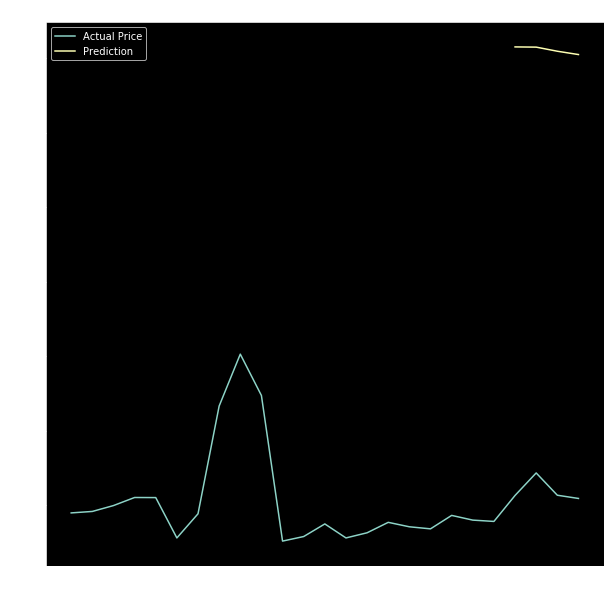

In [0]:
plot_predictions(80000)